# Import the required libraries:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Define the datasets and respective dataloaders

In [2]:
mean = 0.1307
std = 0.3081

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean,), (std,))])

batch_size = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_size = 50000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validation_loader = DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

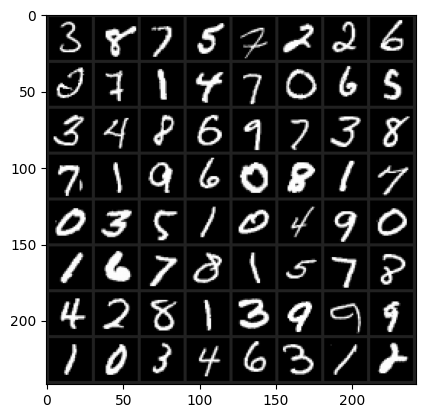

3 8 7 5 7 2 2 6 2 7 1 4 7 0 6 5 3 4 8 6 9 7 3 8 7 1 9 6 0 8 1 7 0 3 5 1 0 4 9 0 1 6 7 8 1 5 7 8 4 2 8 1 3 9 9 9 1 0 3 4 6 3 1 2


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img * std + mean     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

Let's use PyTorch Softmax regression model for the task.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SoftmaxRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return F.log_softmax(out, dim=1) # logprobs

In [5]:
model = SoftmaxRegression(28 * 28, 10)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
import torch
from torch import nn, optim

def train(net, train_dataloader, val_dataloader, epochs=10, lr=0.001, device='cpu', print_every=10):
    '''
        net: Softmax Regression model
        train_dataloader: train dataloader
        val_dataloader: validation dataloader
        epochs: number of epochs
        lr: learning rate
        device: device_type (GPU or CPU)
        print_every: number of steps for printing loss
    '''
    print(f'Start training on {device}')
    net.train()

    opt = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)
    net.to(device)

    for e in range(epochs):
        running_loss = 0
        step = 0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            net.zero_grad()
            output = net(inputs)
            loss = criterion(output, targets)
            loss.backward()
            opt.step()
            step += 1
            running_loss += loss.item()

            if step % print_every == 0:

                net.eval()
                with torch.no_grad():
                    accuracy = 0
                    for val_inputs, val_targets in val_dataloader:
                        val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                        val_output = net(val_inputs)
                        val_loss = criterion(val_output, val_targets)

                        top_p, top_class = val_output.topk(1, dim=1)
                        equals = top_class == val_targets.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                print(f"Epoch: {e+1}/{epochs}.. "
                      f"Training Loss: {running_loss/print_every:.3f}.. "
                      f"Validation Loss: {val_loss/print_every:.3f}.. "
                      f"Validation Accuracy: {accuracy/len(val_dataloader):.3f}"
                      )
                running_loss = 0
                net.train()


In [8]:
train(net=model,train_dataloader=train_loader, val_dataloader=validation_loader, epochs=1)

Start training on cpu
Epoch: 1/1.. Training Loss: 2.003.. Validation Loss: 0.137.. Validation Accuracy: 0.563
Epoch: 1/1.. Training Loss: 1.232.. Validation Loss: 0.094.. Validation Accuracy: 0.713
Epoch: 1/1.. Training Loss: 0.932.. Validation Loss: 0.095.. Validation Accuracy: 0.786
Epoch: 1/1.. Training Loss: 0.747.. Validation Loss: 0.094.. Validation Accuracy: 0.822
Epoch: 1/1.. Training Loss: 0.586.. Validation Loss: 0.068.. Validation Accuracy: 0.827
Epoch: 1/1.. Training Loss: 0.613.. Validation Loss: 0.111.. Validation Accuracy: 0.840
Epoch: 1/1.. Training Loss: 0.542.. Validation Loss: 0.021.. Validation Accuracy: 0.858
Epoch: 1/1.. Training Loss: 0.441.. Validation Loss: 0.064.. Validation Accuracy: 0.863
Epoch: 1/1.. Training Loss: 0.546.. Validation Loss: 0.046.. Validation Accuracy: 0.867
Epoch: 1/1.. Training Loss: 0.483.. Validation Loss: 0.111.. Validation Accuracy: 0.873
Epoch: 1/1.. Training Loss: 0.499.. Validation Loss: 0.050.. Validation Accuracy: 0.875
Epoch: 1/1

Evaluate the model on test dataset:

In [28]:
def evaluate(model, test_loader, device='cpu', one_batch=False, inputs=None, labels=None):
    """
    Evaluate the model on the test set.

    Parameters:
    model: Trained model to be evaluated
    test_loader: DataLoader for the test set
    device: Device on which to evaluate the model ('cpu' or 'cuda')

    Returns:
    List[Tuple[torch.Tensor, torch.Tensor]]: List of tuples containing predicted and actual labels
    """
    model.eval()
    model.to(device)

    predictions = []

    with torch.no_grad():
        if one_batch:
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(list(zip(predicted.cpu().numpy(), labels.cpu().numpy())))
            return predictions
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(list(zip(predicted.cpu().numpy(), labels.cpu().numpy())))

    return predictions

predictions = evaluate(model=model, test_loader=testloader, device='cpu')



In [13]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [23]:
from torchmetrics import ConfusionMatrix

def print_confusion_matrix(predictions):

    predicted, labels = zip(*predictions)

    predictions_tensor = torch.tensor(predicted)
    labels_tensor = torch.tensor(labels)

    confmat = ConfusionMatrix(num_classes=10, task='multiclass')
    conf_matrix = confmat(predictions_tensor, labels_tensor)

    print(conf_matrix.numpy())

In [24]:
print_confusion_matrix(predictions=predictions)


[[ 962    0    1    1    0    4   10    1    1    0]
 [   0 1102    2    2    1    2    4    1   21    0]
 [  11   12  898   21   17    1   13   14   40    5]
 [   3    2   14  925    2   20    5   14   16    9]
 [   1    2    4    0  936    1   12    1    4   21]
 [  11    3    5   44   13  751   25    8   24    8]
 [  10    3    4    1    9    7  920    2    2    0]
 [   2    9   21    9   10    0    1  938    1   37]
 [  12    7    8   23   16   29   14    9  843   13]
 [  12    7    2   15   68    5    1   29    5  865]]


Define the fast gradient sign method

In [39]:
def fgsm_attack(model, loss_fn, images, labels, epsilon):
    """
    Perform FGSM attack on a batch of images.

    Parameters:
    model (torch.nn.Module): The neural network model.
    loss_fn: Loss function used to compute the gradient.
    images (torch.Tensor): Input images.
    labels (torch.Tensor): True labels for the input images.
    epsilon (float): The attack step size (perturbation amount).

    Returns:
    torch.Tensor: Adversarial images.
    """

    images.requires_grad = True
    model.eval()
    perturbed_images = images
    outputs = model(images)
    model.zero_grad()

    loss = loss_fn(outputs, labels)

    loss.backward()

    data_grad = images.grad.data.sign()
    perturbed_images = perturbed_images + epsilon * data_grad

    perturbed_images = torch.clamp(perturbed_images, 0, 1)

    return perturbed_images


In [43]:
dataiter = iter(testloader)
images, labels = next(dataiter)

perturbed_images = fgsm_attack(model, criterion, images,labels, 1)

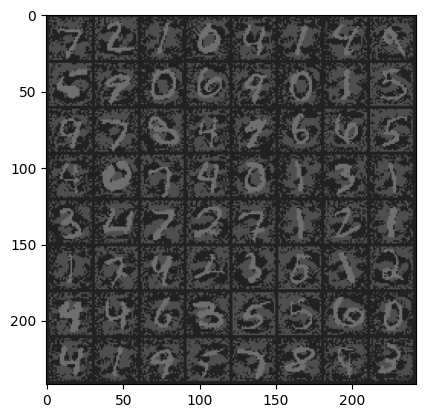

In [46]:
imshow(torchvision.utils.make_grid(perturbed_images))

In [47]:
corrupted_predictions = evaluate(model, testloader, device='cpu', one_batch=True, inputs=perturbed_images, labels=labels)

print_confusion_matrix(predictions=corrupted_predictions)

[[0 0 0 1 0 1 2 0 2 0]
 [0 0 0 5 0 0 0 1 4 0]
 [0 0 0 1 0 1 2 0 1 0]
 [0 0 1 0 0 2 1 0 1 1]
 [0 0 0 0 0 0 1 0 3 6]
 [0 0 0 2 1 0 2 1 1 0]
 [1 0 1 0 1 0 0 0 2 0]
 [0 0 1 4 0 0 0 0 0 2]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 6 0 0 0 0 0]]
